In [1]:
import sys
sys.path.insert(1, '../Codes_1Dtree')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import torch
from torch_geometric.loader import DataLoader
from data.graph_dataset import OneDDatasetBuilder, OneDDatasetLoader, normalize
# from networks.gcn import GraphUNet, RecurrentFormulationNet
from networks.gcnv6 import RecurrentFormulationNet, GraphNet
import matplotlib.pyplot as plt
from torch_geometric.loader import NeighborLoader
from networks.losses import LpLoss

In [3]:
class objectview(object):
    def __init__(self, d) -> None:
        self.__dict__ = d
    def setattr(self, attr_name, attr_value):
        self.__dict__[attr_name] = attr_value

args = objectview({
    'n_fields': 1,
    'n_meshfields': (13, 0),
    'hidden_size': 512,
    'n_layers': 10,
    'n_timesteps': 201,
    'n_previous_timesteps': 1,
    'aggr': 'sum',
    'act': 'relu',
    'dropout': 0.05,
    # 'use_hidden': True,
    'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    'lr': 5e-5,
    # 'lr_decay': 0.5,
    # 'lr_decay_period': 50,
    'weight_decay': 5e-4,
    'n_epoch': 10000,
    'alpha': 1.0,
    'batch_size': 100,
    'timestep': 201,
    'timeslice_hops': 0,
    'timeslice_steps': 1,
    'n_data_per_batch': 50,
    'forward_sequence': False,
    'criterion': LpLoss(),
    'plot': False
})

In [27]:
dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_node_features',
    sub_dir='normalized',
    subjects='all',
    time_names=[str(i).zfill(3) for i in range(201)],
    data_type = torch.float32
)
dataset1 = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_node_features',
    sub_dir='processed',
    subjects='all',
    time_names=[str(i).zfill(3) for i in range(201)],
    data_type = torch.float32
)

In [25]:
model = GraphNet(
    n_fields=args.n_fields,
    n_meshfields=args.n_meshfields,
    n_timesteps=args.n_timesteps,
    hidden_size=args.hidden_size,
    n_layers=args.n_layers,
    n_previous_timesteps=args.n_previous_timesteps,
    # act=args.act,
    dropout=args.dropout,
    # use_hidden=args.use_hidden
)
setattr(model, 'name', 'model_GraphUNet')
model = model.to(args.device)
model.load_state_dict(torch.load(f'models/{model.name}_node2_epoch200.pth', map_location=args.device) )

<All keys matched successfully>

torch.Size([59856, 201, 1]) torch.Size([59856, 201, 1])


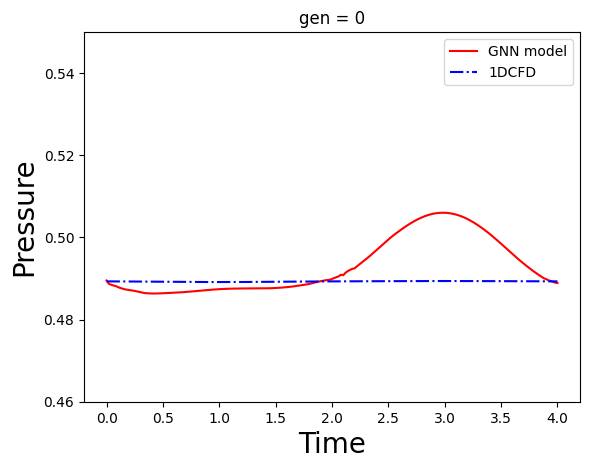

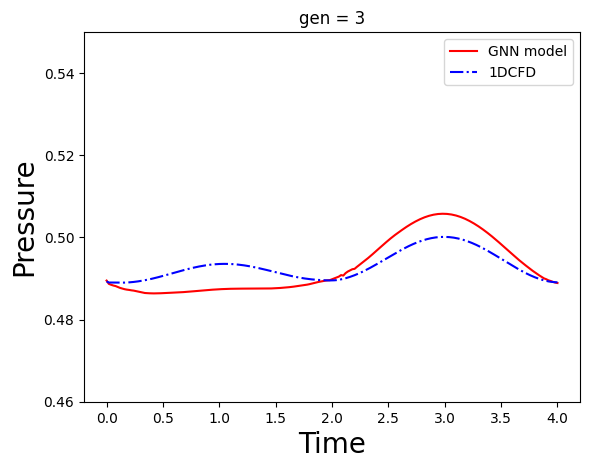

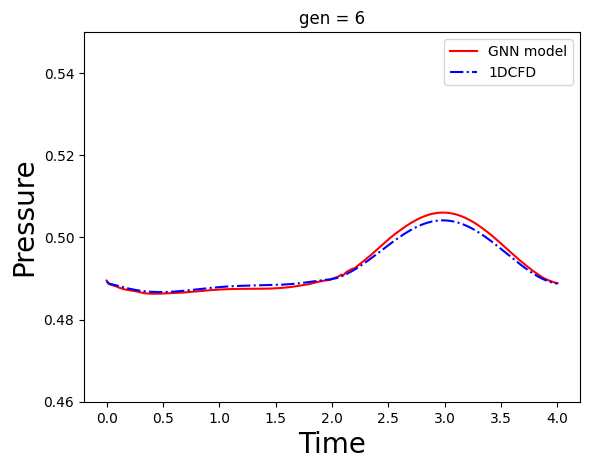

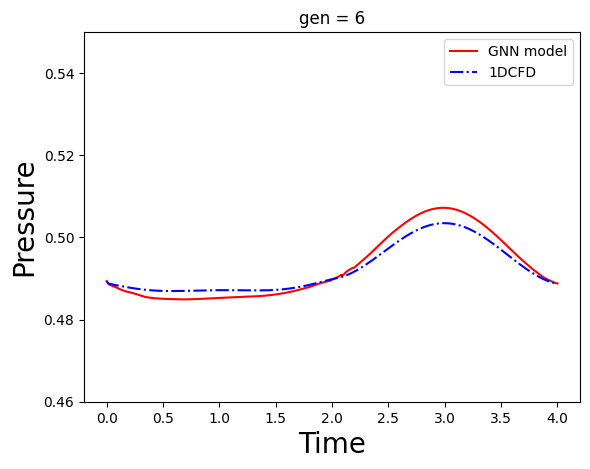

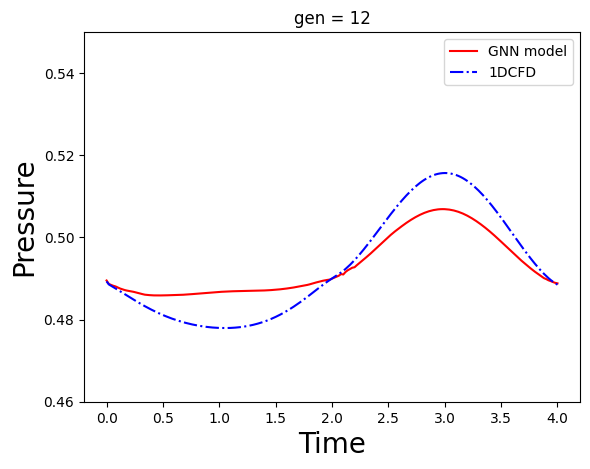

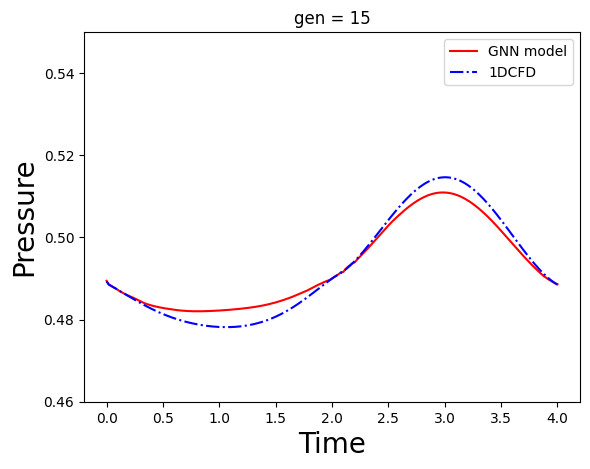

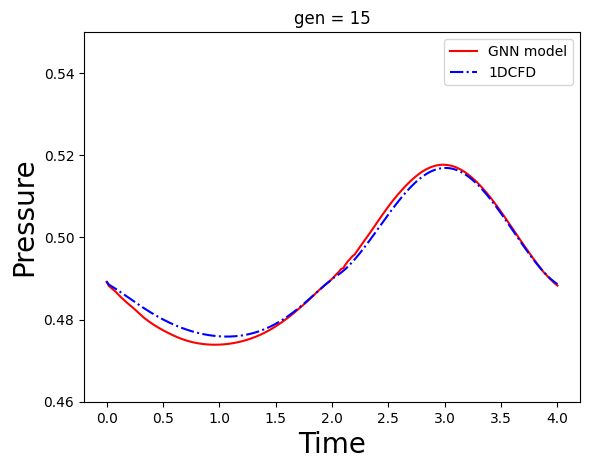

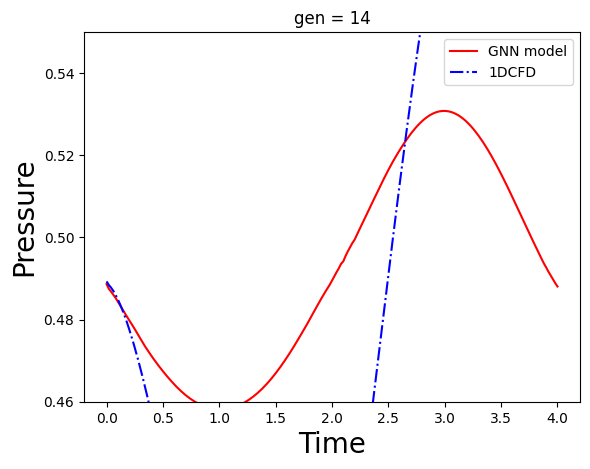

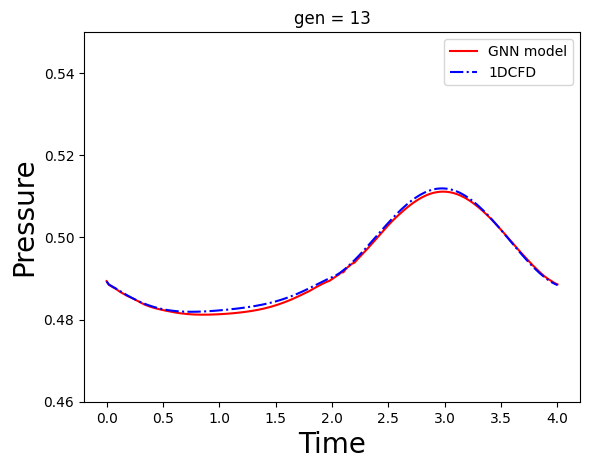

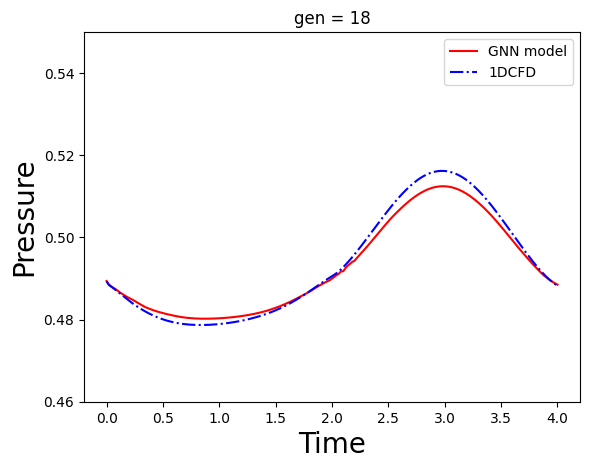

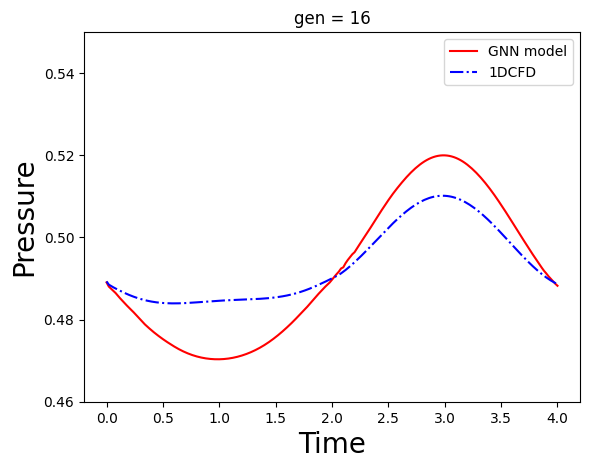

In [32]:
i_data = 30
data = dataset[i_data]


##
F_true = torch.cat([data.pressure.unsqueeze(2)], dim=2) \
            .float().to(args.device)

##
edge_index = torch.cat([data.edge_index, torch.flip(data.edge_index, dims=[0])], dim=1).to(args.device)
##
meshfield = (data.node_attr.float().to(args.device), None)
##
model.eval()

with torch.no_grad():
    
    F_pred = model.forward(
        edge_index=edge_index,
        meshfield=meshfield
    )
# F_pred = torch.transpose(F_pred, 1, 2)
print(F_true.size(), F_pred.size())

loss = args.criterion(F_pred, F_true)



##
gen = dataset1[i_data].node_attr[:,5]
node_list = [1, 10, 50, 100, 1000, 2000, 5000, 20000, 30000, 40000, 50000]
## Draw pressure
import matplotlib.pyplot as plt
for i_node in node_list:
    i_field = 0
    y_pred = F_pred.cpu().numpy()[i_node,:,i_field]
    y_true = F_true.cpu().numpy()[i_node,:,i_field]

    # print(y_true.shape, y_pred.shape)
    x = [i * 4.0 /200 for i in range(y_pred.shape[0])]
    # print(data.node_attr.numpy()[i_node, 6])
    # plt.ylim(-1,1)
    plt.title(f'gen = {int(gen[i_node])}')
    plt.plot(x, y_pred, c='red', label='GNN model')
    plt.plot(x, y_true, c='blue', linestyle='dashdot', label='1DCFD')
    plt.ylim([0.46,0.55])
    plt.legend(loc='upper right')
    plt.ylabel('Pressure', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.show()

# ##
# # node_list = [1000, 5000, 20000, 40000]
# ## Draw pressure
# import matplotlib.pyplot as plt
# for i_node in node_list:
#     i_field = 1
#     y_pred = F_pred.cpu().numpy()[i_node,:,i_field]
#     y_true = F_true.cpu().numpy()[i_node,:,i_field]
#     # print(y_true, y_pred)
#     x = [i * 4.0 /200 for i in range(y_pred.shape[0])]
#     # print(data.node_attr.numpy()[i_node, 6])
#     plt.ylim(-1,1)
#     plt.plot(x, y_pred, c='red', label='GNN model')
#     plt.plot(x, y_true, c='blue', linestyle='dashdot', label='1DCFD')
#     # plt.ylim([-1,1])
#     plt.legend(loc='upper right')
#     plt.ylabel('Flowrate', fontsize=20)
#     plt.xlabel('Time', fontsize=20)
#     plt.show()


In [7]:
# import sys
# sys.path.insert(1, '../Codes_1Dtree')
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# import torch
# from networks.gcnv6 import GraphConv, build_multilayers_graphconv, \
#         RecurrentFormulationNet

# # net = GraphConv(
# #     in_channels=3,
# #     out_channels=5
# # )

# # net = build_multilayers_graphconv(
# #     in_channels=3,
# #     out_channels=3,
# #     hidden_size=128,
# #     n_layers=10,
# #     act='mish'
# # )

# net = RecurrentFormulationNet(
#     n_fields=3,
#     n_meshfields=13,
#     hidden_size=128,
#     n_layers=2,
# )

# F_0 = torch.ones(size=(4,3)).float()
# edge_index = torch.tensor([[0,1,1],[1,2,3]]).type(torch.LongTensor)
# meshfield = torch.ones(size=(4,13)).float()

# inputs = {
#     'F_0' : F_0,
#     'edge_index' : edge_index,
#     'meshfield' : meshfield,
# }

# # x = torch.ones(size=(4,3)).float()
# # edge_index = torch.tensor([[0,1,1],[1,2,3]]).type(torch.LongTensor)
# # edge_attr = torch.ones(size=(3,4)).float()

# # inputs = {
# #     'x' : x,
# #     'edge_index' : edge_index,
# # #     'edge_attr' : edge_attr
# # }

# out = net(F_0, edge_index, meshfield, n_timesteps=5)